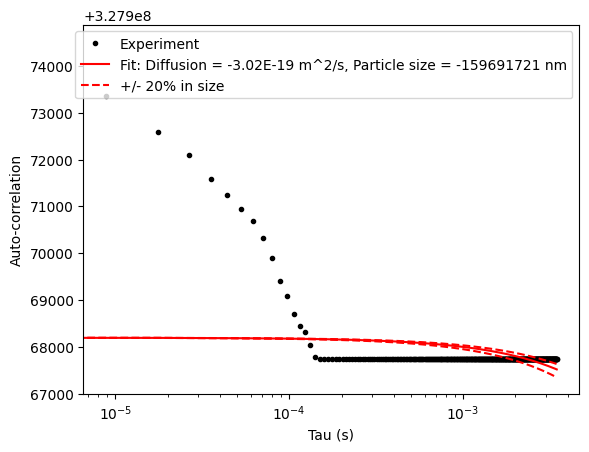

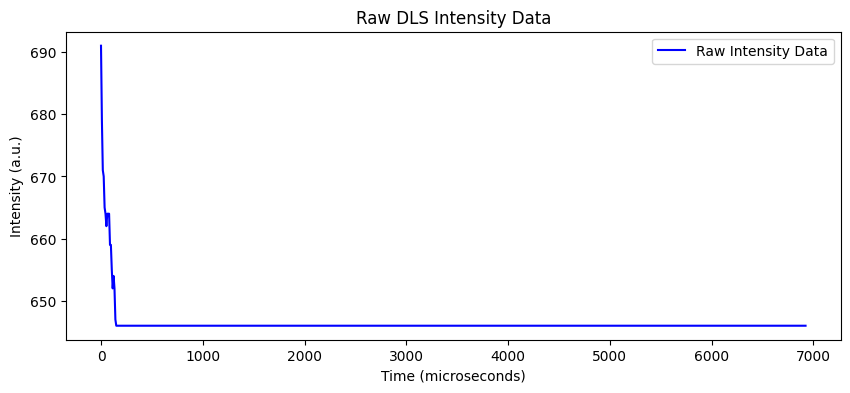

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Constants
lambd = 635e-9          # [m] Laser wavelength
n_s = 1.3325              # Solvent refractive index at wavelength
k = 1.380649e-23        # [J/K] Boltzmann constant
T = 293.15                 # [K] Temperature
eta_s = 0.0089          # [Pa.s] Solvent viscosity measurement at T
theta = np.pi / 2       # Scattering angle

selected_range = [0, 799]

# Read data
df = pd.read_csv("subsets.csv")
time, y_data = df['Time(microseconds)'][selected_range[0]:selected_range[1]] * 1e-6, df['Data_set 0'][selected_range[0]:selected_range[1]]
#Time (seconds),DLS Value,Temperature
# df = pd.read_csv("data_output2_run1-15drops.csv")
# time, y_data = df['Time (seconds)'][selected_range[0]:selected_range[1]] * 1e-6, df['DLS Value'][selected_range[0]:selected_range[1]]
# print(time)

# y_data = y_data / max(y_data) # Normalize?

# Function to compute autocorrelation
def autocorrelate(series):
    N = len(series)
    s_hat = np.fft.rfft(series)
    return np.fft.irfft(s_hat * np.conj(s_hat), N)

# Ensure N_points is defined dynamically
N_points = len(y_data)

# Scattering vector
q = 4 * np.pi / lambd * n_s * np.sin(theta / 2)

# Time array for autocorrelation
tau = time[:N_points // 2]

# Compute autocorrelation and accumulate it
auto_cum = np.zeros(N_points)
auto = autocorrelate(y_data)  # Compute the autocorrelation
auto_cum += auto  # Update cumulative autocorrelation

# Use only the first half of the autocorrelation data
ydata = auto_cum[:N_points // 2]

# Function to fit
def g(tau, a, b, c):
    return a * np.ones_like(tau) + b * np.exp(-c * tau)

# Initial guess
a0 = ydata[-1]
b0 = ydata[0] - a0
# c0 = 2 * q**2 * k * T / (18 * 1e-7 * eta_s)
c0 = 2 * q**2 * k * T / (6 * np.pi * eta_s)

# Fit the curve
popt, pcov = curve_fit(g, tau, ydata, p0=[a0, b0, c0])
(a, b, c) = popt

# Extract hydrodynamic radius from fit
# print(c)
D = c / (2 * q**2)                  # Diffusion coefficient
Rh = k * T / (6 * np.pi * D * eta_s) # Hydrodynamic radius
psize = 2 * Rh * 1e9                 # Particle size in nanometers

# Extract error
perr = np.sqrt(np.diag(pcov))
dc_over_c = perr[2] / c
psizeerr = dc_over_c * psize

# Plot results
plt.semilogx(tau, ydata, 'k.', label='Experiment')
plt.semilogx(tau, g(tau, a, b, c), 'r-', label='Fit: Diffusion = %.2E m^2/s, Particle size = %d nm' % (D, psize))
plt.semilogx(tau, g(tau, a, b, 0.83 * c), 'r--', label='+/- 20% in size')
plt.semilogx(tau, g(tau, a, b, 1.25 * c), 'r--')
plt.xlabel('Tau (s)')
plt.ylabel('Auto-correlation')
plt.legend()

# Plot raw intensity data with iteration number
plt.figure(figsize=(10, 4))
plt.plot(time*1e6, y_data, 'b-', label='Raw Intensity Data')
plt.xlabel('Time (microseconds)')
plt.ylabel('Intensity (a.u.)')
plt.title('Raw DLS Intensity Data')
plt.legend()

plt.show()


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Constants for Stokes-Einstein equation
k_B = 1.380649e-23  # Boltzmann constant (J/K)
T = 298.15  # Temperature in Kelvin (25°C)
eta = 0.00089  # Viscosity of water in Pa·s

# Load data
df = pd.read_csv("micros_5drops.csv")  # Ensure this is the correct file

# Select the relevant range
selected_range = [50, 800]
time_values = df['Time(microseconds)'].iloc[selected_range[0]:selected_range[1]].reset_index(drop=True)
intensity_values = df['DLS Value'].iloc[selected_range[0]:selected_range[1]].reset_index(drop=True)

# Normalize intensity
intensity_norm = intensity_values / np.max(intensity_values)

# Define decay threshold (1/e)
threshold = 1 / np.e

# Find decay index using threshold method
decay_indices = np.where(intensity_norm <= threshold)[0]

if len(decay_indices) == 0:
    raise ValueError("No valid decay index found. Check intensity values.")

# Select the first reasonable decay point, skipping initial noise
decay_index = decay_indices[np.argmax(decay_indices > 10)]  # Ensure we skip noise

# Extract decay time (τ) in microseconds
tau = time_values.iloc[decay_index]

# Check if tau is reasonable
print(f"Corrected decay time (tau): {tau} µs")

# Compute diffusion coefficient D (D = 1 / (2τ)), converting μs to s
D = 1 / (2 * tau * 1e-6)  # Convert microseconds to seconds

# If D is unreasonably large, switch to curve fitting method
if D > 1e-8:  
    print("Warning: Diffusion coefficient too large, trying curve fitting method.")

    # Define exponential decay function
    def exp_decay(t, A, tau_fit):
        return A * np.exp(-t / tau_fit)

    # Restrict fitting to the first 150 points to avoid noise
    fit_range = 150
    time_fit = time_values[:fit_range]
    intensity_fit = intensity_norm[:fit_range]

    # Fit the decay curve with reasonable bounds (τ should be between 10 μs and 5000 μs)
    try:
        popt, _ = curve_fit(exp_decay, time_fit, intensity_fit, p0=[1, 1000], bounds=([0, 10], [1, 5000]))
        tau = popt[1]  # New decay time
        print(f"Fitted decay time (tau): {tau:.2f} µs")
    except RuntimeError:
        print("Curve fitting failed. Using initial threshold-based τ.")
    
    # Recalculate D with new tau
    D = 1 / (2 * tau * 1e-6)

# Compute particle size in nanometers using Stokes-Einstein equation
particle_size_nm = (k_B * T) / (3 * np.pi * eta * D) * 1e9  # Convert meters to nanometers

# Print outputs
print(f"Threshold value: {threshold}")
print(f"Normalized intensity values (first 20 points):\n{intensity_norm[:20]}")
print(f"Decay indices found: {decay_indices}")
print(f"Final decay index used: {decay_index}")
print(f"Final decay time (tau): {tau} µs")
print(f"Final estimated particle size: {particle_size_nm:.2f} nm")

# Plot decay curve for visualization
plt.figure(figsize=(8, 5))
plt.plot(time_values, intensity_norm, label="Normalized Intensity")
plt.axvline(tau, color="red", linestyle="--", label=f"Tau = {tau:.2f} µs")
plt.axhline(threshold, color="green", linestyle="--", label="1/e Threshold")
plt.xlabel("Time (μs)")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.title("DLS Intensity Decay Curve")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'micros_5drops.csv'

In [23]:
def particle_size(time, y_data):
    # Ensure N_points is defined dynamically
    N_points = len(y_data)

    # Scattering vector
    q = 4 * np.pi / lambd * n_s * np.sin(theta / 2)

    # Time array for autocorrelation
    tau = time[:N_points]

    # Compute autocorrelation and accumulate it
    auto_cum = np.zeros(N_points)
    auto = autocorrelate(y_data)  # Compute the autocorrelation
    auto_cum += auto  # Update cumulative autocorrelation

    # Use only the first half of the autocorrelation data
    ydata = auto_cum[:N_points]

    # Function to fit
    def g(tau, a, b, c):
        return a * np.ones_like(tau) + b * np.exp(-c * tau)

    # Initial guess
    a0 = ydata[-1]
    b0 = ydata[0] - a0
    c0 = 2 * q**2 * k * T / (18 * 1e-7 * eta_s)

    # Fit the curve
    popt, pcov = curve_fit(g, tau, ydata, p0=[a0, b0, c0])
    (a, b, c) = popt

    # Extract hydrodynamic radius from fit
    D = c / (2 * q**2)                  # Diffusion coefficient
    Rh = k * T / (6 * np.pi * D * eta_s) # Hydrodynamic radius
    psize = 2 * Rh * 1e9                 # Particle size in nanometers

    return psize

In [3]:
def psize_per_file(filename):
    df = pd.read_csv(filename)
    time_all, y_data_all = df['Time (seconds)'], df['DLS Value']

    start = 0
    psize = np.empty(len(range(20, len(time_all), 20)))
    for i, end in enumerate(range(20, len(time_all), 20)):
        time, y_data = time_all[start: end], y_data_all[start:end]
        
        try:
            size = particle_size(time, y_data)
            psize[i] = size
            print(f'Size: {size} | Start: {start} | End: {end}')
        except:
            psize[i] = np.nan
            print(f'FAILED | Start: {start} | End: {end}')

        start = end

    iteration = np.array(range(20, len(time_all), 20), dtype=float)
    iteration[psize == np.nan] = np.nan

    return iteration, psize

In [4]:
file_vs_size = {}
all_files = ['data_output_good.csv', 'data_output_run2.csv', 'data_output_run3.csv', 'data_output_run4.csv', 'data_output_run5.csv']
for filename in all_files:
    print(f'FILENAME: {filename}')
    iteration, psize = psize_per_file(filename)
    file_vs_size[filename] = [iteration, psize]

    print('')

FILENAME: data_output_good.csv
Size: 87.84768490021762 | Start: 0 | End: 20
FAILED | Start: 20 | End: 40
Size: 190.98593171027437 | Start: 40 | End: 60
Size: 190.98593171027437 | Start: 60 | End: 80
Size: 190.98593171027437 | Start: 80 | End: 100
Size: 190.98593171027437 | Start: 100 | End: 120
Size: 190.98593171027437 | Start: 120 | End: 140
Size: 190.98593171027437 | Start: 140 | End: 160
Size: 190.98593171027437 | Start: 160 | End: 180
Size: 190.98593171027437 | Start: 180 | End: 200
Size: 190.98593171027437 | Start: 200 | End: 220
Size: 190.98593171027437 | Start: 220 | End: 240
Size: 190.98593171027437 | Start: 240 | End: 260
Size: 190.98593171027437 | Start: 260 | End: 280
Size: 190.98593171027437 | Start: 280 | End: 300
Size: 190.98593171027437 | Start: 300 | End: 320
Size: 190.98593171027437 | Start: 320 | End: 340
Size: 190.98593171027437 | Start: 340 | End: 360
Size: 190.98593171027437 | Start: 360 | End: 380
Size: 190.98593171027437 | Start: 380 | End: 400
Size: 190.98593171

C:\Users\jmste\AppData\Local\Temp\ipykernel_7820\148852586.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(g, tau, ydata, p0=[a0, b0, c0])


Size: 190.98593171027437 | Start: 1640 | End: 1660
Size: 190.98593171027437 | Start: 1660 | End: 1680
Size: 190.98593171027437 | Start: 1680 | End: 1700
Size: 190.98593171027437 | Start: 1700 | End: 1720
Size: 190.98593171027437 | Start: 1720 | End: 1740
Size: 190.98593171027437 | Start: 1740 | End: 1760
Size: 190.98593171027437 | Start: 1760 | End: 1780
Size: 190.98593171027437 | Start: 1780 | End: 1800
Size: 190.98593171027437 | Start: 1800 | End: 1820
Size: 190.98593171027437 | Start: 1820 | End: 1840
Size: 190.98593171027437 | Start: 1840 | End: 1860
Size: 190.98593171027437 | Start: 1860 | End: 1880
Size: 190.98593171027437 | Start: 1880 | End: 1900
Size: 190.98593171027437 | Start: 1900 | End: 1920
Size: 190.98593171027437 | Start: 1920 | End: 1940
Size: 190.98593171027437 | Start: 1940 | End: 1960
Size: 190.98593171027437 | Start: 1960 | End: 1980
Size: 190.98593171027437 | Start: 1980 | End: 2000
Size: 190.98593171027437 | Start: 2000 | End: 2020
Size: 190.98593171027437 | Star

C:\Users\jmste\AppData\Local\Temp\ipykernel_7820\148852586.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(g, tau, ydata, p0=[a0, b0, c0])
C:\Users\jmste\AppData\Local\Temp\ipykernel_7820\148852586.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(g, tau, ydata, p0=[a0, b0, c0])


FAILED | Start: 0 | End: 20
Size: 0.38565947429238595 | Start: 20 | End: 40
Size: 190.98593171027437 | Start: 40 | End: 60
Size: 190.98593171027437 | Start: 60 | End: 80
Size: 190.98593171027437 | Start: 80 | End: 100
Size: 190.98593171027437 | Start: 100 | End: 120
Size: 190.98593171027437 | Start: 120 | End: 140
Size: 190.98593171027437 | Start: 140 | End: 160
Size: 190.98593171027437 | Start: 160 | End: 180
Size: 190.98593171027437 | Start: 180 | End: 200
Size: 190.98593171027437 | Start: 200 | End: 220
Size: 190.98593171027437 | Start: 220 | End: 240
Size: 190.98593171027437 | Start: 240 | End: 260
Size: 190.98593171027437 | Start: 260 | End: 280
Size: 190.98593171027437 | Start: 280 | End: 300

FILENAME: data_output_run5.csv
Size: 16.07656704526363 | Start: 0 | End: 20
Size: 0.27652626508812694 | Start: 20 | End: 40
Size: 190.98593171027437 | Start: 40 | End: 60
Size: 190.98593171027437 | Start: 60 | End: 80
Size: 190.98593171027437 | Start: 80 | End: 100
Size: 190.98593171027437 

C:\Users\jmste\AppData\Local\Temp\ipykernel_7820\148852586.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(g, tau, ydata, p0=[a0, b0, c0])
C:\Users\jmste\AppData\Local\Temp\ipykernel_7820\148852586.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(g, tau, ydata, p0=[a0, b0, c0])


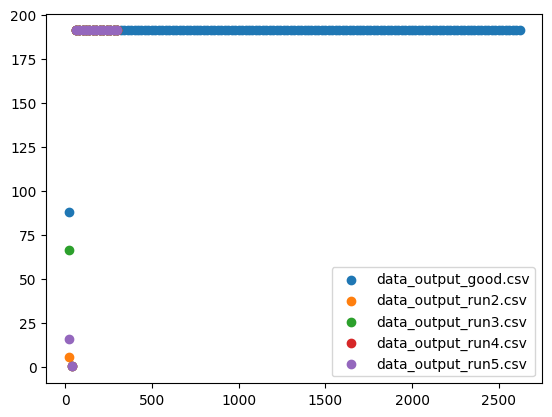

In [5]:
for key, value in file_vs_size.items():
    plt.scatter(value[0], value[1], label=key)

plt.legend()
plt.show()

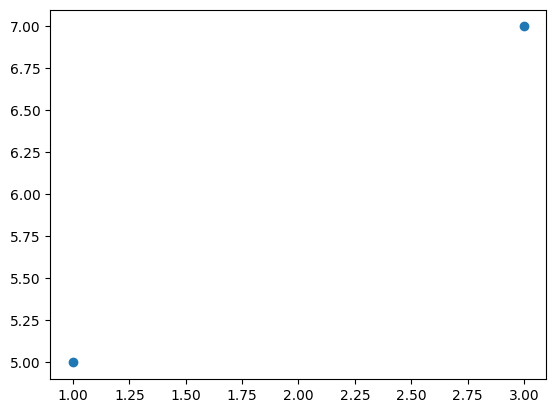

In [19]:
x = np.array([1, np.nan, 3])
y = np.array([5, 6, 7])
plt.scatter(x, y)